In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2022-08-29 19:37:18.568381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 19:37:18.568426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model = keras.models.load_model('../output/NER_model_updated.h5')
model.summary()

2022-08-29 19:37:21.070001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-29 19:37:21.070044: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 19:37:21.070071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (TudorMLTest1): /proc/driver/nvidia/version does not exist
2022-08-29 19:37:21.070349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 50)           468000    
                                                                 
 dropout (Dropout)           (None, 300, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 400)         401600    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 300, 8)           3208      
 ibuted)                                                         
                                                                 
Total params: 872,808
Trainable params: 872,808
Non-trainable

# Pipeline
This is an example of a full pipeline of a sentence that needs to be predicted.

Steps:
1. Apply pre-processing (replace the dots and the commas)
2. Split the words
3. Import the embeddings (created from the dataset)
4. Pad the sequence
5. Predict
6. ???
7. Profit

In [10]:
# word and tag 2 index
# max_len = 50
# word2idx = {w: i for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}


# Sentence to predict
sentence = 'EXW QTY: 192 UNITS CONCENTRATE 7-UP, AS PER BENEFICIARY\'S SALES QUOTATION NO. 790005454 DATED 02.01.2020'


# Apply pre-processing steps from before
def replace_dots(x):
    return x.replace(':',' ')

def replace_comma(x):
    return x.replace(',','')

sentence = replace_dots(replace_comma(sentence))

words = sentence.split()

import pickle
# Save the embeddings
with open("words_embeddings", "rb") as fp: 
    word2idx = pickle.load(fp)


# Embedding
X = []
for word in words:
    X.append(word2idx[word])
X

max_len = 300 # taken from ner_nn.ipynb
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=max_len, sequences=[X], padding="post", value=len(word2idx)-1)

# Apply the predict function
output = model.predict(X)

with open("tags_embeddings", "rb") as fp: 
    tag2idx = pickle.load(fp)
tag2idx = list(tag2idx)
tag2idx

predicted_output = []
for word in output[0]:
    predicted_output.append(tag2idx[word.argmax()])

for i in range(len(words)):
    print('Original word: ', words[i], '=== Predicted Tag: ', predicted_output[i])
# predicted_output

Original word:  EXW === Predicted Tag:  Incoterms
Original word:  QTY === Predicted Tag:  O
Original word:  192 === Predicted Tag:  Quantity
Original word:  UNITS === Predicted Tag:  Quantity
Original word:  CONCENTRATE === Predicted Tag:  GoodsDescription
Original word:  7-UP === Predicted Tag:  GoodsDescription
Original word:  AS === Predicted Tag:  O
Original word:  PER === Predicted Tag:  O
Original word:  BENEFICIARY'S === Predicted Tag:  O
Original word:  SALES === Predicted Tag:  O
Original word:  QUOTATION === Predicted Tag:  O
Original word:  NO. === Predicted Tag:  O
Original word:  790005454 === Predicted Tag:  O
Original word:  DATED === Predicted Tag:  O
Original word:  02.01.2020 === Predicted Tag:  O


In [11]:
df = pd.read_csv('../data/dataset_from_json.csv')

words = list(df[df['sentence #'] == 0]['words'])

X = []
for word in words:
    X.append(word2idx[word])

max_len = 300 # taken from ner_nn.ipynb

from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(maxlen=max_len, sequences=[X], padding="post", value=len(word2idx)-1)
X.shape

(1, 300)

In [12]:
_y = model.predict(X)
_y.shape

(1, 300, 8)

In [14]:
for tag in df[df['sentence #'] == 0]['tag']:
    print(tag2idx.index(tag), tag)

4 Incoterms
4 Incoterms
4 Incoterms
4 Incoterms
2 O
0 Quantity
0 Quantity
2 O
3 GoodsDescription
3 GoodsDescription
3 GoodsDescription
3 GoodsDescription
3 GoodsDescription
2 O


In [15]:
y_pred = []
for word in _y[0]:
    y_pred.append(tag2idx[word.argmax()])

y = list(df[df['sentence #'] == 0]['tag'])
for i in range(len(y_pred)-len(y)):
    y.append('O')


for i, val in enumerate(zip(y, y_pred)):
    if i < 10:
        print('Actual', val, 'Predicted')

Actual ('Incoterms', 'Incoterms') Predicted
Actual ('Incoterms', 'Incoterms') Predicted
Actual ('Incoterms', 'Incoterms') Predicted
Actual ('Incoterms', 'Incoterms') Predicted
Actual ('O', 'O') Predicted
Actual ('Quantity', 'Quantity') Predicted
Actual ('Quantity', 'Quantity') Predicted
Actual ('O', 'O') Predicted
Actual ('GoodsDescription', 'GoodsDescription') Predicted
Actual ('GoodsDescription', 'GoodsDescription') Predicted


<Figure size 1080x1080 with 0 Axes>

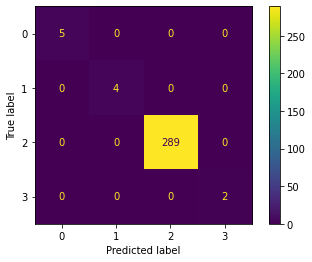

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
conf_matrix.plot()
plt.show()

In [17]:
for i, v in enumerate(tag2idx):
    print(i, v)

0 Quantity
1 UnitPriceAmount
2 O
3 GoodsDescription
4 Incoterms
5 GoodsOrigin
6 Tolerance
7 HSCode
